In [3]:
## bert tokenization library file
!wget  https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

--2020-06-07 18:22:37--  https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16775 (16K) [text/plain]
Saving to: ‘tokenization.py’

tokenization.py     100%[===================>]  16.38K  --.-KB/s    in 0.01s   

2020-06-07 18:22:37 (1.60 MB/s) - ‘tokenization.py’ saved [16775/16775]



In [5]:
!pip install sentencepiece 

     |████████████████████████████████| 1.1MB 3.5MB/s 


In [0]:
import cv2
import warnings
import pickle
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling2D, Concatenate, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg19 import VGG19
from keras.utils import np_utils
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tokenization
import os


In [32]:
## reading training tweets data
trainData = pd.read_csv("thesis-task/dataset/tweets.txt", delimiter="	")
splitData = pd.concat([pd.Series(row["tweetId"],  row["imageId(s)"].split(','))              
                    for _, row in trainData.iterrows()]).reset_index(name="tweetId")
trainData = trainData.merge(splitData,how='outer',left_on=['tweetId'],right_on=['tweetId'])
del trainData["imageId(s)"]
trainData.rename(columns={'index':'imageId(s)'}, inplace=True)
trainData["imageId(s)"] = trainData["imageId(s)"].str.strip()
for dir, _, files in os.walk('thesis-task/dataset/images/'):
    imageList = files
imgs = trainData["imageId(s)"].unique()
for i, image in enumerate(imageList):
    image = image.split('.')[0]
    imageList[i] = image

imageList.remove('boston_fake_10')  ## format video;  not available
trainData = trainData.loc[trainData['imageId(s)'].isin(imageList)]
trainData

,tweetId,tweetText,userId,username,timestamp,label,imageId(s)
0,263046056240115712,¿Se acuerdan de la película “El día después de...,21226711,iAnnieM,Mon Oct 29 223401 +0000 2012,fake,sandyA_fake_46
1,262995061304852481,@milenagimon Miren a Sandy en NY! Tremenda im...,192378571,CarlosVerareal,Mon Oct 29 191123 +0000 2012,fake,sandyA_fake_09
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,LucasPalape,Mon Oct 29 181108 +0000 2012,fake,sandyA_fake_09
3,262996108400271360,Scary shit #hurricane #NY httpt.coe4JLBUfH,241995902,Haaaaarryyy,Mon Oct 29 191533 +0000 2012,fake,sandyA_fake_29
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,princess__natt,Mon Oct 29 204602 +0000 2012,fake,sandyA_fake_15
...,...,...,...,...,...,...,...
14622,443231991593304064,@BobombDom slaps TweetDeck with the PigFish ht...,2179310905,Da_Vault_Hunter,Tue Mar 11 03 48 36 +0000 2014,fake,pigFish_01
14623,443086239127076865,New Species of Fish found in Brazil or just Re...,254843101,DjSituation_RC,Mon Mar 10 18 09 26 +0000 2014,fake,pigFish_01
14624,442978105238753280,What do we call this #pigFISH http t.co4Bml62OD15,2367553228,Vivo1Vuyo,Mon Mar 10 10 59 45 +0000 2014,fake,pigFish_01
14625,442753479782989824,Pigfish E dopo il pescecane c'è il pesce maia...,603120231,CosimoTarta,Sun Mar 09 20 07 10 +0000 2014,fake,pigFish_01


In [33]:
## class wise train data distribution and their count 
dataDistribution = trainData.groupby(['label'], sort=True).size().reset_index(name='Count')
dataDistribution

,label,Count
0,fake,6844
1,humor,2631
2,real,5025


In [34]:
#### generating validation dataset (train/validation split)
valData = trainData.groupby(['label'],as_index=False).apply(lambda x: x.sample(frac=0.1))
valData
trainData = pd.concat([trainData,valData, valData]).drop_duplicates(keep=False)
dataDistribution = valData.groupby(['label'], sort=True).size().reset_index(name='Count')
print("Validation set class distribution")
display(dataDistribution.head())
print("Training set class distribution")
dataDistribution = trainData.groupby(['label'], sort=True).size().reset_index(name='Count')
dataDistribution.head()    

Validation set class distribution


,label,Count
0,fake,684
1,humor,263
2,real,502


Training set class distribution


,label,Count
0,fake,6160
1,humor,2368
2,real,4519


In [35]:
## reading test tweets data
testData = pd.read_csv("thesis-task/testset/tweets.txt", delimiter="	")
splitData = pd.concat([pd.Series(row["tweetId"],  row["imageId(s)"].split(','))              
                    for _, row in testData.iterrows()]).reset_index(name="tweetId")
print(splitData.shape)
testData = testData.merge(splitData,how='outer',left_on=['tweetId'],right_on=['tweetId'])
del testData["imageId(s)"]
testData.rename(columns={'index':'imageId(s)'}, inplace=True)
testData["imageId(s)"] = testData["imageId(s)"].str.strip()
for dir, _, files in os.walk('thesis-task/testset/images/'):
    imageList = files
imgs = testData["imageId(s)"].unique()
print(len(imgs))
for i, image in enumerate(imageList):
    image = image.split('.')[0]
    imageList[i] = image

imageList.remove('syrian_boy_video')  ## format video;  not available
testData = testData.loc[testData['imageId(s)'].isin(imageList)]
testData

(3865, 2)
51


,tweetId,tweetText,userId,username,timestamp,label,imageId(s)
0,578854927457349632,kereeen RT @Shyman33: Eclipse from ISS.... htt...,70824972,peay_s,Fri Mar 20 09:45:43 +0000 2015,fake,eclipse_01
1,578874632670953472,Absolutely beautiful! RT @Shyman33: Eclipse fr...,344707006,JaredUcanChange,Fri Mar 20 11:04:02 +0000 2015,fake,eclipse_01
2,578891261353984000,“@Shyman33: Eclipse from ISS.... http://t.co/C...,224839607,tpjp1231,Fri Mar 20 12:10:06 +0000 2015,fake,eclipse_01
3,578846612312748032,Eclipse from ISS.... http://t.co/En87OtvsU6,134543073,Shyman33,Fri Mar 20 09:12:41 +0000 2015,fake,eclipse_01
4,578975333841551360,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,1150728872,Epimethee_,Fri Mar 20 17:44:11 +0000 2015,fake,eclipse_01
...,...,...,...,...,...,...,...
2030,583783882182430722,"In honor of our fellow Students, we pray the g...",2492068440,Instaadict,Fri Apr 03 00:11:38 +0000 2015,real,garissa_04
2031,583869095633911808,The horror image from inside #Kenya campus #Ga...,255109494,bleqdipSA,Fri Apr 03 05:50:14 +0000 2015,real,garissa_04
2032,583813623425998848,#BREAKING \n🔴WARNING! 🔞📷GRAPHIC CONTENT🔞\nDeat...,514063845,marpipeas,Fri Apr 03 02:09:49 +0000 2015,real,garissa_04
2033,583857897030975490,it hurts : @joansalihi : The image from\ninsid...,1082284466,mage_amos,Fri Apr 03 05:05:44 +0000 2015,real,garissa_04


In [36]:
## class wise data distribution and their count 
dataDistribution = testData.groupby(['label'], sort=True).size().reset_index(name='Count')
dataDistribution

,label,Count
0,fake,821
1,real,1212


In [0]:
## training labels encoding to one-hot vector
trainLabels = trainData["label"]
encoder = LabelEncoder()
encoder.fit(trainLabels)
trainLabels = encoder.transform(trainLabels)
trainLabels= np_utils.to_categorical(trainLabels)

## test labels encoding to one-hot vector
testLabels = testData["label"]
testLabels = encoder.transform(testLabels)
testLabels= np_utils.to_categorical(testLabels)

In [38]:
## loading bert pre-trained model
%time
bertUrl = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2"
bertLayer = hub.KerasLayer(bertUrl, trainable=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [0]:
## instantiating tokenizer class object
vocab_file = bertLayer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bertLayer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
## randomly checking tweet and its tokens pre-processing
tweet = data["tweetText"].iloc[i]
print(tweet, "\n\n")
input_sequence = tokenizer.tokenize(tweet)
print(len(input_sequence))
tokens = tokenizer.convert_tokens_to_ids(input_sequence)
print(len(tokens))

#Sandy wildin'... Sharks in the streets... No one is safe... #RNS #Hurricane #wave httpt.co2QKzhF6f 


40
40


max Length of tweet for 95% of tweets : 50


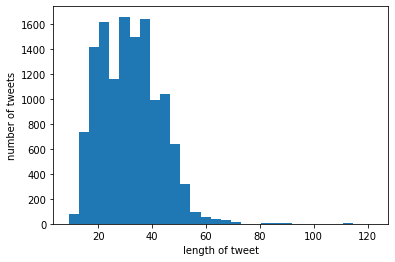

In [40]:
## finding the length distribution of tweets
tweetsLength = [len(tokenizer.tokenize(tweet)) for tweet in trainData["tweetText"].tolist()]
%matplotlib inline
np.random.seed(42)
x = np.random.normal(size=1000)
plt.hist(tweetsLength, density=False, bins=30) 
plt.xlabel('length of tweet')
plt.ylabel('number of tweets')
maxLen = int(np.percentile(tweetsLength, 95))
print("max Length of tweet for 95% of tweets :", maxLen)

In [0]:
### encoding text sequence/tweet into bert model format
def bert_encode(texts, tokenizer, max_len):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence =["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [1]:
### train/validation data generator for batch wise model training

def dataGenerator(data, batch_size): 
    while True:
        tweetsList = data["tweetText"].tolist()
        imageIds = data["imageId(s)"].tolist()
        trainInput = []
        trainImages = []
        labels = []
        for dir, _, files in os.walk('thesis-task/dataset/images/'):
            imageList = files
        # print(len(imageList))
        for i,imageId in enumerate(imageIds):
            imageFile = [s for s in imageList if imageIds[i] in s][0]
            image = cv2.imread('thesis-task/dataset/images/'+imageFile)
            image = cv2.resize(image, (224,224))
            trainImages.append(image)
            labels.append(trainLabels[i])
            if((i+1)%batch_size==0):
                trainText = bert_encode(tweetsList[i-batch_size+1:i+1], tokenizer, int(maxLen))
                trainInput = [trainText[0], trainText[1], trainText[2], np.array(trainImages)]
                yield trainInput, np.array(labels)
                trainInput = [] 
                trainImages = []
                labels = []

In [0]:
### test data generator for batch wise model evaluation/testing
def testDataGenerator(data, batch_size): 
    while True:
      tweetsList = data["tweetText"].tolist()
      imageIds = data["imageId(s)"].tolist()
      trainInput = []
      trainImages = []
      labels = []
      for dir, _, files in os.walk('thesis-task/testset/images/'):
          imageList = files
      # print(len(imageList))
      for i,imageId in enumerate(imageIds):
          imageFile = [s for s in imageList if imageIds[i] in s][0]
          image = cv2.imread('thesis-task//testset/images/'+imageFile)
          image = cv2.resize(image, (224,224))
          trainImages.append(image)
          labels.append(testLabels[i])
          if((i+1)%batch_size==0):
              trainText = bert_encode(tweetsList[i-batch_size+1:i+1], tokenizer, int(maxLen))
              trainInput = [trainText[0], trainText[1], trainText[2], np.array(trainImages)]
              yield trainInput, np.array(labels)
              trainInput = [] 
              trainImages = []
              labels = []

In [0]:
## Bert and Vgg Model initialization
def getBertModel(bert_layer, maxLen):
    input_word_ids = Input(shape=(maxLen,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(maxLen,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(maxLen,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    print(clf_output)
    hiddenLayer = Dense(768, activation='relu')(clf_output)  
    dropOut = Dropout(0.4)(hiddenLayer)
    hiddenLayer = Dense(32, activation='relu', name="bert-last")(dropOut)
    dropOut = Dropout(0.4)(hiddenLayer)
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=dropOut)
#     model.compile(Adam(lr=1e-5), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    return model


def getVggModel():
    vggModel = VGG19(weights='imagenet', include_top=False, input_shape = (224,224, 3))
    vggModel.trainable = False
    flatLayer = Flatten()
    hiddenLayer1 = Dense(2742, activation='relu')
    dropOut = Dropout(0.4)
    hiddenLayer2 = Dense(32, activation='relu', name="vgg-last")
    dropOut = Dropout(0.4)
    vggModel = tf.keras.Sequential([
      vggModel,
      flatLayer,
      hiddenLayer1,
      dropOut,
      hiddenLayer2, dropOut
    ])
#     vggModel.compile(Adam(lr=1e-5), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    return vggModel

In [46]:
## define model arhcitecture

##define VGG model
vggModel = getVggModel()

## define BERT model
bertModel = getBertModel(bertLayer, int(maxLen))

## concatenate and combine models
print(bertModel.output, vggModel.output)
concatLayer = tf.keras.layers.Concatenate(name="concat-layer")([bertModel.output, vggModel.output])
combinedlayer = Dense(64, activation='relu')(concatLayer)
combinedlayer = Dropout(0.4)(combinedlayer)
combinedlayer = Dense(35, activation='relu')(combinedlayer)
combinedlayer = Dropout(0.4)(combinedlayer)
outputLayer = Dense(1, activation='sigmoid')(combinedlayer)

model = Model(
    [bertModel.input, vggModel.input],
    outputLayer                        
) 
model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=Adam(lr=1e-3, decay=1e-3 / 200), metrics=[ 'accuracy', tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC', summation_method='interpolation', name=None,
    dtype=None, thresholds=None, multi_label=False, label_weights=None
)
])

80142336/80134624 [==============================] - 1s 0us/step
Tensor("strided_slice:0", shape=(None, 768), dtype=float32)
Tensor("dropout_3/Identity:0", shape=(None, 32), dtype=float32) Tensor("dropout_1_1/Identity:0", shape=(None, 32), dtype=float32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 50)]         0                                            
___________________________________

In [71]:
### model training
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)
trainGen = dataGenerator(trainData, batch_size=8)
valGen = dataGenerator(valData, batch_size=8)
history = model.fit_generator(
    trainGen,
    validation_data= valGen, validation_steps=18,
    epochs=10, steps_per_epoch=160, callbacks=[callback])

Epoch 1/10
160/160 [==============================] - 42s 263ms/step - loss: 0.0903 - accuracy: 0.9961 - auc: 0.9979 - val_loss: 1.1681e-06 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 2/10
160/160 [==============================] - 42s 260ms/step - loss: 0.4139 - accuracy: 0.9500 - auc: 0.9817 - val_loss: 0.3282 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 3/10
160/160 [==============================] - 41s 259ms/step - loss: 1.1778 - accuracy: 0.6148 - auc: 0.8528 - val_loss: 0.7619 - val_accuracy: 0.6458 - val_auc: 0.8732
Epoch 4/10
160/160 [==============================] - 42s 260ms/step - loss: 0.8330 - accuracy: 0.8781 - auc: 0.9534 - val_loss: 2.9313 - val_accuracy: 0.0000e+00 - val_auc: 0.5000
Epoch 5/10
160/160 [==============================] - 42s 260ms/step - loss: 0.5224 - accuracy: 0.6930 - auc: 0.9201 - val_loss: 1.1739e-06 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 6/10
160/160 [==============================] - 42s 260ms/step - loss: 1.3051 - accuracy: 0.6703 

160/160 [==============================] - 40s 253ms/step - loss: 1.0822 - accuracy: 0.5719 - auc: 0.7331 - val_loss: 0.8073 - val_accuracy: 0.8500 - val_auc: 0.9065


In [72]:
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
with open("spotfake-2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("spotfake-2.h5")
print("Saved model to disk")

!cp -a spotfake-2.h5 "/content/drive/My Drive/thesis-task/model-1"
!cp -a spotfake-2.json "/content/drive/My Drive/thesis-task/model-1"

Saved model to disk


In [2]:
## getting prediction probabilities
dataGen = testDataGenerator(testData, batch_size=8)
yPred = model.predict_generator(dataGen, steps=250)


In [81]:
def getBinaryAccuracy(yPred, yTrue):
  acc = 0
  count = 0
  yPred = yPred > 0.5
  for i in range(len(yPred)):
    predClass = yPred[i]
    trueClass = yTrue[i]
    if(predClass==0):
      count+=1
    if(predClass==trueClass):
      acc+=1
  # print(count)
  return acc/len(yPred)

print(getAccuracy(yPred, testLabels))


0.408


# References
1. https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2   
